Luciano Pinheiro Batista 173096

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(precision = 4)

def Conta_Classes(Label_Set):
    P = np.sum(np.equal(Label_Set, 1))
    N = np.sum(np.equal(Label_Set, 0))
    return np.array([P/(P+N), N/(P+N)])

Train_Images = np.load('train_images.npy')
Train_Labels = np.load('train_labels.npy')

Val_Images = np.load('val_images.npy')
Val_Labels = np.load('val_labels.npy')

Test_Images = np.load('test_images.npy')
Test_Labels = np.load('test_labels.npy')


#Conta_Classes(Train_Labels)
#Conta_Classes(Val_Labels)
#Conta_Classes(Test_Labels)

O balanço entre classes obtido pela função *Conta_Classes* foi igual para os três conjuntos - treino, validação e teste:

- Positivo: **73.08%**
- Negativo: **26.92%**

Há uma predominância da classe positiva, aproximadamente 3 em cada 4 amostras pertencem a esta classe.

In [2]:
#Extração de atributos a partir das imagens

def Atributos(Image_Set, Dim_Image):
    Atributos_Test_Empilhados = np.empty((0, 88))
    for image in Image_Set:
        Soma = np.sum(image) / (Dim_Image ** 2)
        Traco = np.trace(image)
        Autovalores = np.linalg.eig(image)[0]
        Autovalores = np.absolute(Autovalores)
        Soma_Lin = np.array([0])
        Soma_Col = np.array([0])
        for lin in image:
            Soma_Lin = np.hstack((Soma_Lin, np.sum(lin) / Dim_Image))
        for col in image.T:
            Soma_Col = np.hstack((Soma_Col, np.sum(col) / Dim_Image))
        Atributos_Test = np.hstack((Soma, Autovalores, Traco, Soma_Lin, Soma_Col))
        Atributos_Test_Empilhados = np.vstack((Atributos_Test_Empilhados, Atributos_Test)) 
    Fi = np.hstack((np.ones((len(Atributos_Test_Empilhados), 1)), Atributos_Test_Empilhados))
    return Fi
    

Dim_Image = len(Train_Images[0])
Fi_Train = Atributos(Train_Images, Dim_Image)
Fi_Val   = Atributos(Val_Images, Dim_Image)
Fi_Test  = Atributos(Test_Images, Dim_Image)

A função Atributos foi utilizada para extrair os seguintes atributos para cada imagem:

- Média da soma dos elementos.
- Traço da matriz.
- Valores absolutos dos autovalores.
- Média da soma dos elementos de cada linha.
- Média da soma dos elementos de cada coluna.

Outros atributos, como determinante e parte real dos autovalores, foram testados, contudo os atributos acima foram os que proporcionaram os melhores resultados. Os atributos de cada imagem foram empilhados e a matriz Fi de cada conjunto - treino, validação e teste - foi gerada.

In [3]:
#Treinamento
def Calcula_Grad(Fi_Train, w, Train_Labels):
    E = np.empty((0, 1))
    for i in range(len(Fi_Train)):
        Label_Calc = 1 / (1 + np.exp(-(np.dot(Fi_Train[i], w))))
        Erro = Train_Labels[i][0] - Label_Calc
        E = np.vstack((E, Erro))
    Grad = - 1/len(Fi_Train) * (np.matmul(E.T, Fi_Train))
    return Grad[0]

w = np.loadtxt('Melhor_Parametro') 


Alfa = .0001
for i in range(3000):
    w  = w - Alfa * Calcula_Grad(Fi_Train, w, Train_Labels)
    if i % 1000 == 0: 
        print(i)
        


0
1000
2000


Para o treinamento foi utilizado o método do gradiente descendente em batelada, utilizando a função *Calcula_Grad*. A escolha é coerente com base no tamanho do conjunto de dados deste problema. A rotina implementa uma função logística, com base nos atributos e vetor de parâmetros. O passo $\alpha$ e o número de épocas de treinamento foram ajustados com base nos melhores valores de Acurácia Balanceada e Precisão alcançados na etapa de validação. Isto foi obtido com $\alpha = .0001$ e $10000$ épocas. Além disso, foi observado que o valor inicial do vetor de parâmetros também altera fundamentalmente os resultados. Os melhores resultados foram obtios com uma inicialização aleatória, seguindo uma distribuição uniforme no conjunto $[0, 1)$. Após a obtenção do melhor vetor de parâmetros, o modelo foi treinado novamente utilizando como condições iniciais o próprio vetor de parâmetros encontrado, com $3000$ épocas. Os resultados obtidos se mostraram ainda melhores. 

In [35]:
#Validacao
Label_Calcs = np.empty((0,1))
for i in range(len(Fi_Val)):
    Label_Calc = 1 / (1 + np.exp(-(np.dot(Fi_Val[i], w))))
    if Label_Calc >= 0.5:
        Label_Calc = 1
    else:
        Label_Calc = 0
    Label_Calcs = np.vstack((Label_Calcs, Label_Calc))
    

TP = np.sum(np.equal(Label_Calcs, 1) & np.equal(Val_Labels, 1))
FP = np.sum(np.equal(Label_Calcs, 1) & np.equal(Val_Labels, 0))
FN = np.sum(np.equal(Label_Calcs, 0) & np.equal(Val_Labels, 1))
TN = np.sum(np.equal(Label_Calcs, 0) & np.equal(Val_Labels, 0))
    

Matriz_Conf = np.array([[TP, FN], 
                        [FP, TN]])    
    
Espe = TN / (TN + FP)
Sens = TP / (TP + FN)
Prec = TP / (TP + FP)
TFPo = FP / (TN + FP)

BA = (Espe + Sens) / 2
Acc = (TP + TN) / (TP + TN + FP + FN)
Fm = (2 * Sens * Prec) / (Sens + Prec)

print(BA, Acc, Fm)


0.8107769423558897 0.8333333333333334 0.8828828828828829


Para a validação foi utilizado o vetor de parâmetros obtido na etapa de treinamento. O limite utilizado para a escolha da classe foi de 0.5. Se o padrão calculado for maior que 0.5 o classificador escolhe classe positiva, caso contrário, escolhe classe negativa. A matriz de confusão foi calculada e com base nela as métricas foram calculadas.

In [6]:
#Teste
Label_Calcs = np.empty((0,1))
Label_Calcs_Bruto = np.empty((0,1)) #Será usado para curva ROC
for i in range(len(Fi_Test)):
    Label_Calc = 1 / (1 + np.exp(-(np.dot(Fi_Test[i], w))))
    Label_Calcs_Bruto = np.vstack((Label_Calcs_Bruto, Label_Calc))
    if Label_Calc >= 0.5:
        Label_Calc = 1
    else:
        Label_Calc = 0
    Label_Calcs = np.vstack((Label_Calcs, Label_Calc))
    


TP = np.sum(np.equal(Label_Calcs, 1) & np.equal(Test_Labels, 1))
FP = np.sum(np.equal(Label_Calcs, 1) & np.equal(Test_Labels, 0))
FN = np.sum(np.equal(Label_Calcs, 0) & np.equal(Test_Labels, 1))
TN = np.sum(np.equal(Label_Calcs, 0) & np.equal(Test_Labels, 0))
    

Matriz_Conf = np.array([[TP, FN], 
                        [FP, TN]])    
    
Espe = TN / (TN + FP)
Sens = TP / (TP + FN)
Prec = TP / (TP + FP)
TFPo = FP / (TN + FP)

BA = (Espe + Sens) / 2
Acc = (TP + TN) / (TP + TN + FP + FN)
Fm = (2 * Sens * Prec) / (Sens + Prec)

print(BA, Acc, Fm)


0.7531328320802004 0.782051282051282 0.8454545454545455


Na etapa de teste foi utilizado o melhor vetor de parâmetros obtido na etapa de validação. Com ele os seguintes valores de métricas foram alcançados:

- Acurácia Balanceada  = **0.75**
- Acurácia             = **0.78**
- F-medida             = **0.84**

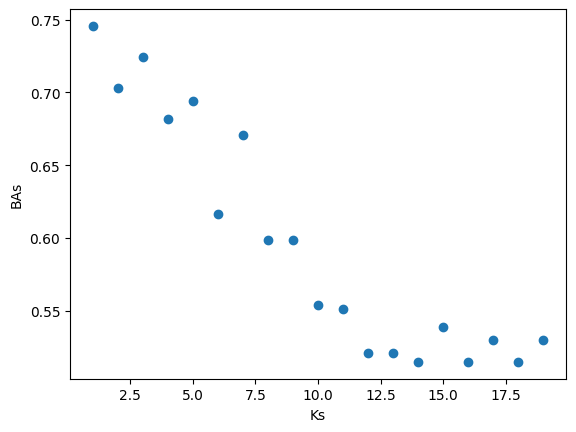

In [8]:
# Knn para a validação
 
def KNN(K, Fi_Set, Fi_Train):
    Label_Calcs_Bruto = np.empty((0,1))
    Label_Calcs = np.empty((0,1))
    for Novo_Padrao in Fi_Set[:, 1:len(Fi_Set[0])]:
        Distancias = np.empty((0, 2))
        for Padrao, Label in zip(Fi_Train[:, 1:len(Fi_Train[0])], Train_Labels):
            Distancia = [np.linalg.norm(Novo_Padrao - Padrao), Label[0]]
            Distancias = np.vstack((Distancias, Distancia))
        Distancias = np.sort(Distancias.view('f8, f8'), order=['f0'], axis=0)
        Distancias = Distancias[0:K]
        Distancias = Distancias.view(dtype = np.float64)
        Label_Calc = np.sum(Distancias, axis = 0)[1] / K
        Label_Calcs_Bruto = np.vstack((Label_Calcs_Bruto, Label_Calc))
        if Label_Calc >= .5:
            Label_Calc = 1
        else:
            Label_Calc = 0
        Label_Calcs = np.vstack((Label_Calcs, Label_Calc))
    return Label_Calcs, Label_Calcs_Bruto

Ks = []
BAs = []
for K in range(1, 20, 1):    
    
    Label_Calcs, Label_Calcs_Bruto = KNN(K, Fi_Val, Fi_Train)

    TP = np.sum(np.equal(Label_Calcs, 1) & np.equal(Val_Labels, 1))
    FP = np.sum(np.equal(Label_Calcs, 1) & np.equal(Val_Labels, 0))
    FN = np.sum(np.equal(Label_Calcs, 0) & np.equal(Val_Labels, 1))
    TN = np.sum(np.equal(Label_Calcs, 0) & np.equal(Val_Labels, 0))


    Matriz_Conf = np.array([[TP, FN], 
                            [FP, TN]])    

    Espe = TN / (TN + FP)
    Sens = TP / (TP + FN)
    Prec = TP / (TP + FP)
    TFPo = FP / (TN + FP)

    BA = (Espe + Sens) / 2
    Acc = (TP + TN) / (TP + TN + FP + FN)
    Fm = (2 * Sens * Prec) / (Sens + Prec)
    
    BAs.append(BA)
    Ks.append(K)

fig, ax = plt.subplots()
ax.scatter(Ks, BAs)
ax.set_xlabel('Ks')
ax.set_ylabel('BAs')
plt.show()

        

A função KNN implementa o método KNN, *K-nearest neighbors* para um certo valor $K$ de vizinhos e para um conjunto alvo, utilizando o conjunto de treinamento como base para o cálculo das distâncias. A função calcula a distância euclidiana de uma novo dado do conjunto de validação aos dados do conjunto de treinamento e atribui o novo rótulo com base nos rótulos dos K dados mais próximos ao novo dado. O gráfico gerado mostra como a acurácia balanceada, obtida utilizando o método KNN para o conjunto de validação, varia conforme o aumento do parâmetro $K$. Essa métrica foi escolhida, pois ela é boa para analisar situações em que há desbalanço entre as classes, como é o caso. Sendo assim, o valor escolhido para a etapa de teste foi $K = 1$, que proporcionou o melhor valor de Acurácia Balanceada.

In [12]:
# Knn para o teste com K = 1
K = 1
Label_Calcs, Label_Calcs_Bruto = KNN(K, Fi_Test, Fi_Train)

TP = np.sum(np.equal(Label_Calcs, 1) & np.equal(Test_Labels, 1))
FP = np.sum(np.equal(Label_Calcs, 1) & np.equal(Test_Labels, 0))
FN = np.sum(np.equal(Label_Calcs, 0) & np.equal(Test_Labels, 1))
TN = np.sum(np.equal(Label_Calcs, 0) & np.equal(Test_Labels, 0))


Matriz_Conf = np.array([[TP, FN], 
                        [FP, TN]])    

Espe = TN / (TN + FP)
Sens = TP / (TP + FN)
Prec = TP / (TP + FP)
TFPo = FP / (TN + FP)

BA = (Espe + Sens) / 2
Acc = (TP + TN) / (TP + TN + FP + FN)
Fm = (2 * Sens * Prec) / (Sens + Prec)

print(BA, Acc, Fm)



0.6578947368421053 0.7307692307692307 0.8157894736842104


Na etapa de teste com K = 1, as métricas de Acurácia Balanceada, Precisão e F-medida, foram calculadas. Nota-se que o desempenho do modelo fica abaixo em todas as três métricas em comparação com os valores obtidos utilizando a regressão logística. A vantagem se dá por conta de que o modelo, por conta do método utilizado, não precisou ser treinado.

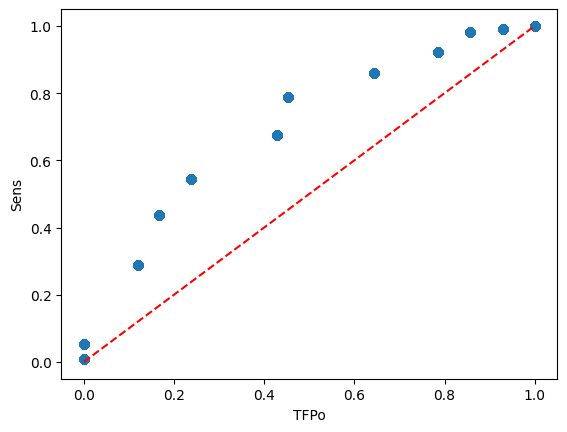

In [33]:
#Curva ROC

Sens = []
TFPo = []
Thresholds = np.arange(0, 1, 0.0001)

# Knn para o teste com K = 20
K = 20
Label_Calcs, Label_Calcs_Bruto = KNN(K, Fi_Test, Fi_Train)

for Threshold in Thresholds:
    
    Label_Calc_ROC = np.empty((0,1))
    for Label_Calc_Bruto in Label_Calcs_Bruto:
        if Label_Calc_Bruto >= Threshold:
            Label_Calc_Bruto = 1
        else:
            Label_Calc_Bruto = 0
        Label_Calc_ROC = np.vstack((Label_Calc_ROC, Label_Calc_Bruto))
    #print(Label_Calc_ROC)

    TP = np.sum(np.equal(Label_Calc_ROC, 1) & np.equal(Test_Labels, 1))
    FP = np.sum(np.equal(Label_Calc_ROC, 1) & np.equal(Test_Labels, 0))
    FN = np.sum(np.equal(Label_Calc_ROC, 0) & np.equal(Test_Labels, 1))
    TN = np.sum(np.equal(Label_Calc_ROC, 0) & np.equal(Test_Labels, 0))
    
    #print(TP, FP, FN, TN)

    Sens.append(TP / (TP + FN)) 
    TFPo.append(FP / (FP + TN))
    
fig, ax = plt.subplots()
ax.scatter(TFPo, Sens)
ax.plot(np.linspace(0, 1, 6), np.linspace(0, 1, 6), '--', color = 'red')
ax.set_xlabel('TFPo')
ax.set_ylabel('Sens')
plt.show()

Por conta de fatores computacionais, a curva ROC para o método de regressão logística não ficou muito clara. A função utilizada cravava os valores altos em um, deixando pouca margem para a geração da curva. Assim a curva ROC foi levantada para o método KNN utilizando K = 20. Para diferentes limitantes, os valores de Sensibilidade e Taxa de Falso Positivo foram calculados. Percebe-se que o seu desempenho é de fato melhor que o classificador aleatório, caracterizado pela linha diagonal tracejada.